# 实战-图像生成文本
## 意义
- 结合cnn rnn
- 属于有监督学习

## 没有dnn问题
- 无法提取图像抽象特征表示
- 无法生成含有语义信息的文本
- 只能采用匹配的方式对于图像进行文本匹配
    - 这种方法生成能力弱 泛化特性差
    
## 应用
- 图像搜索
    - 丰富图像搜索元数据 增强搜索效果
    - 在早期 都是通过提取图像的特征 之后再搜索元数据为图像特征的众多结果中进行特征匹配
    > 搜索元数据 ：搜索时进行匹配的信息 如：文本搜索中网页中的文字 图片匹配时网页中的图片特征 
    - 而现在的技术实现将图片特征->文本(搜索元数据改变，文本作为搜索元数据更容易)

- 盲人导航 盲人自拍
- 少儿教育

## 评测
- BLEU score
    - 与机器翻译类似 生成文本 所以可以用相似的评测指标
- 图像检索评测指标
    - 间接应用领域评测
- 人工评测

### BLEU Score
- 基本思想：n-gram match 从而得到生成文本与目标文本的匹配程度 (n-gram 是指n个词的组)
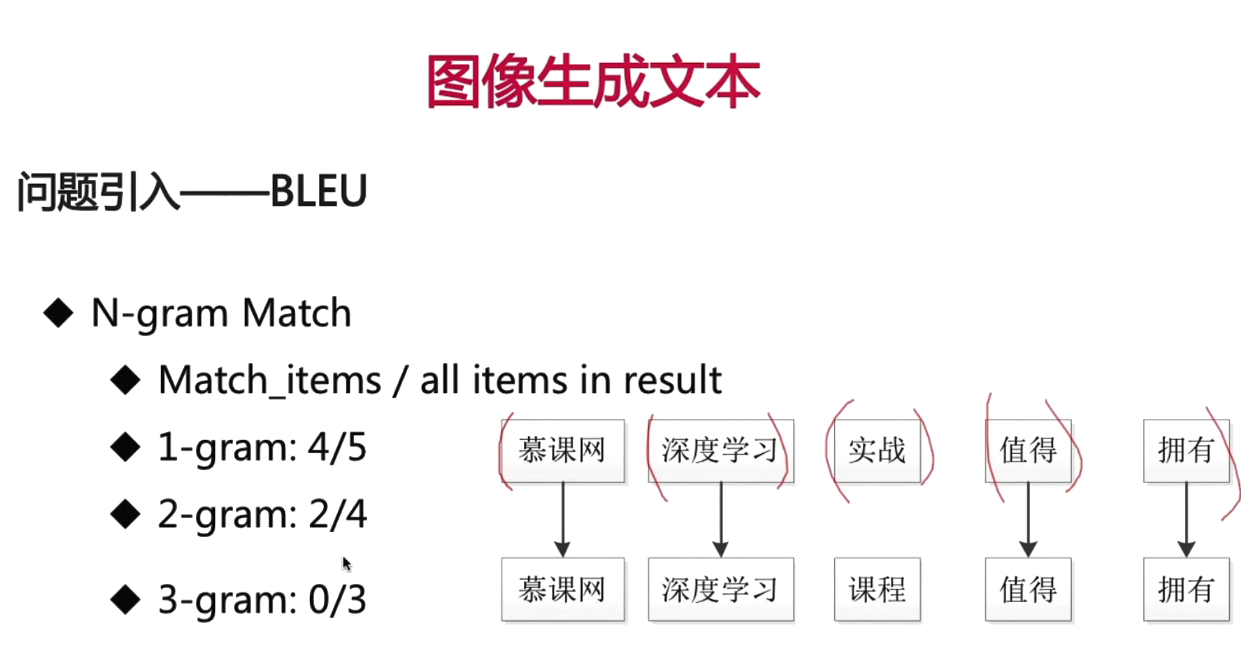
- 基本问题以及优化
    - 重复虚高->用目标中出现次数做最小化惩罚
    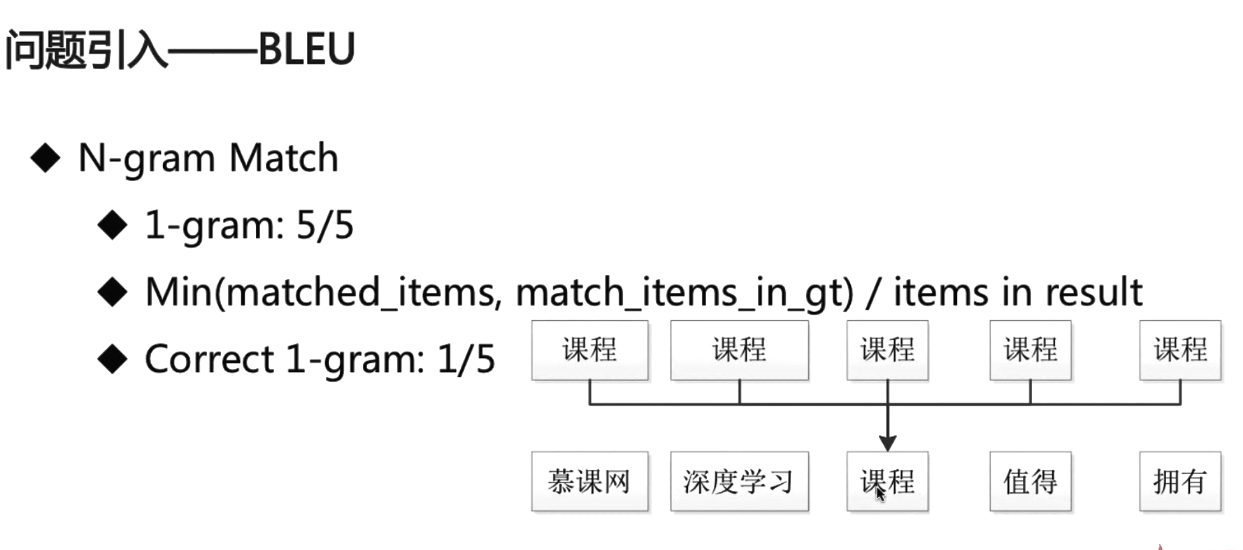
    - 短句倾向->用目标长度对比做loss惩罚
    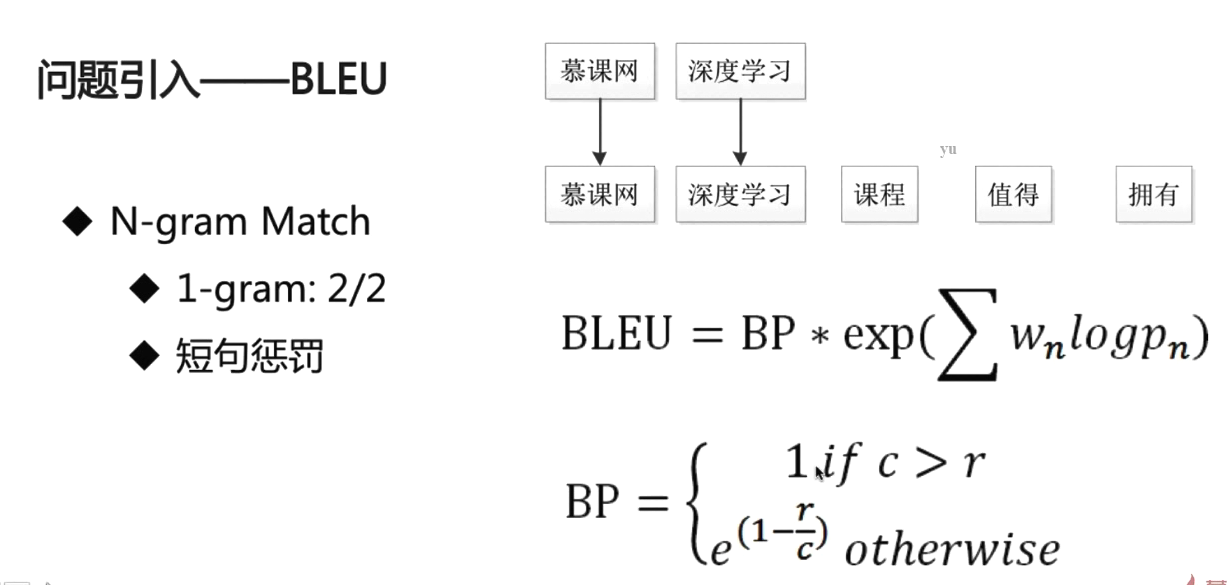

## 模型框架

### 基本架构

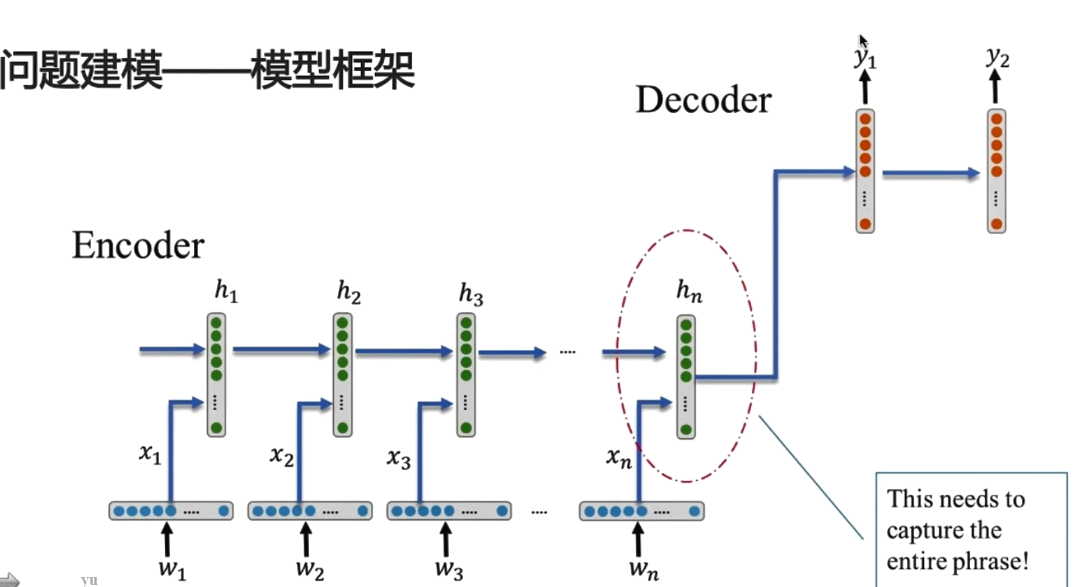
- encoder + decoder 模型
- 模仿机器翻译模型
    - lstm + lstm -> cnn + lstm
    - lstm 都负责生成文本 只是提取输入特征方式不同

### 生成文本技术
- Beam Search
    - 基本思想
    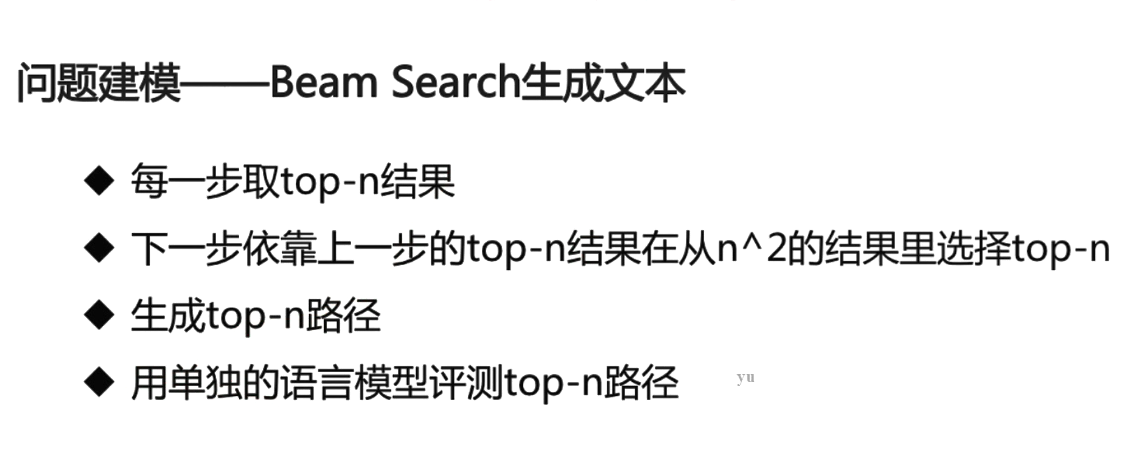
    - 实例
    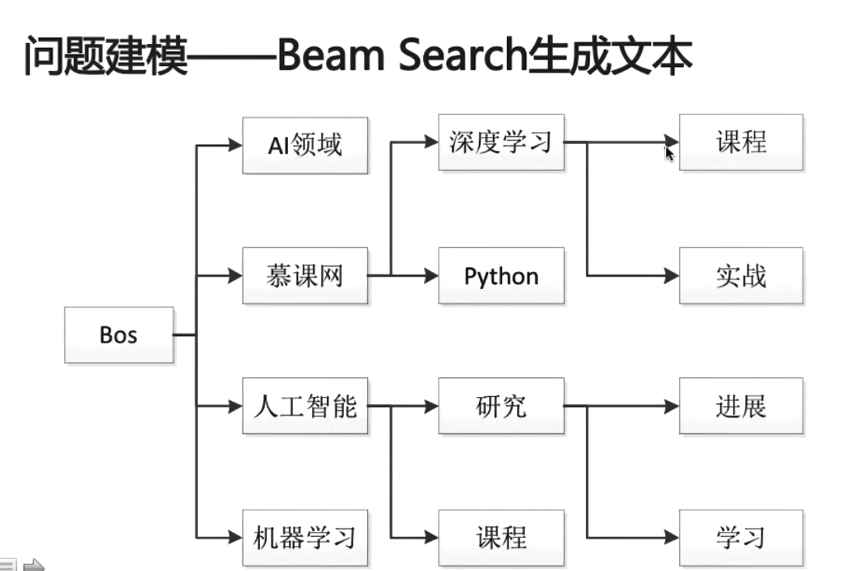
    - 优势： 
        - 解决贪心方法(每次选取输出中最高概率词)导致的缺乏语义问题
        - 保证了大概率 + 语义信息
        - 在现代搜索技术中 广泛使用 尤其在多步关联问题中

## 基本模型
### model1 - multi-modal Rnn
- 基本结构
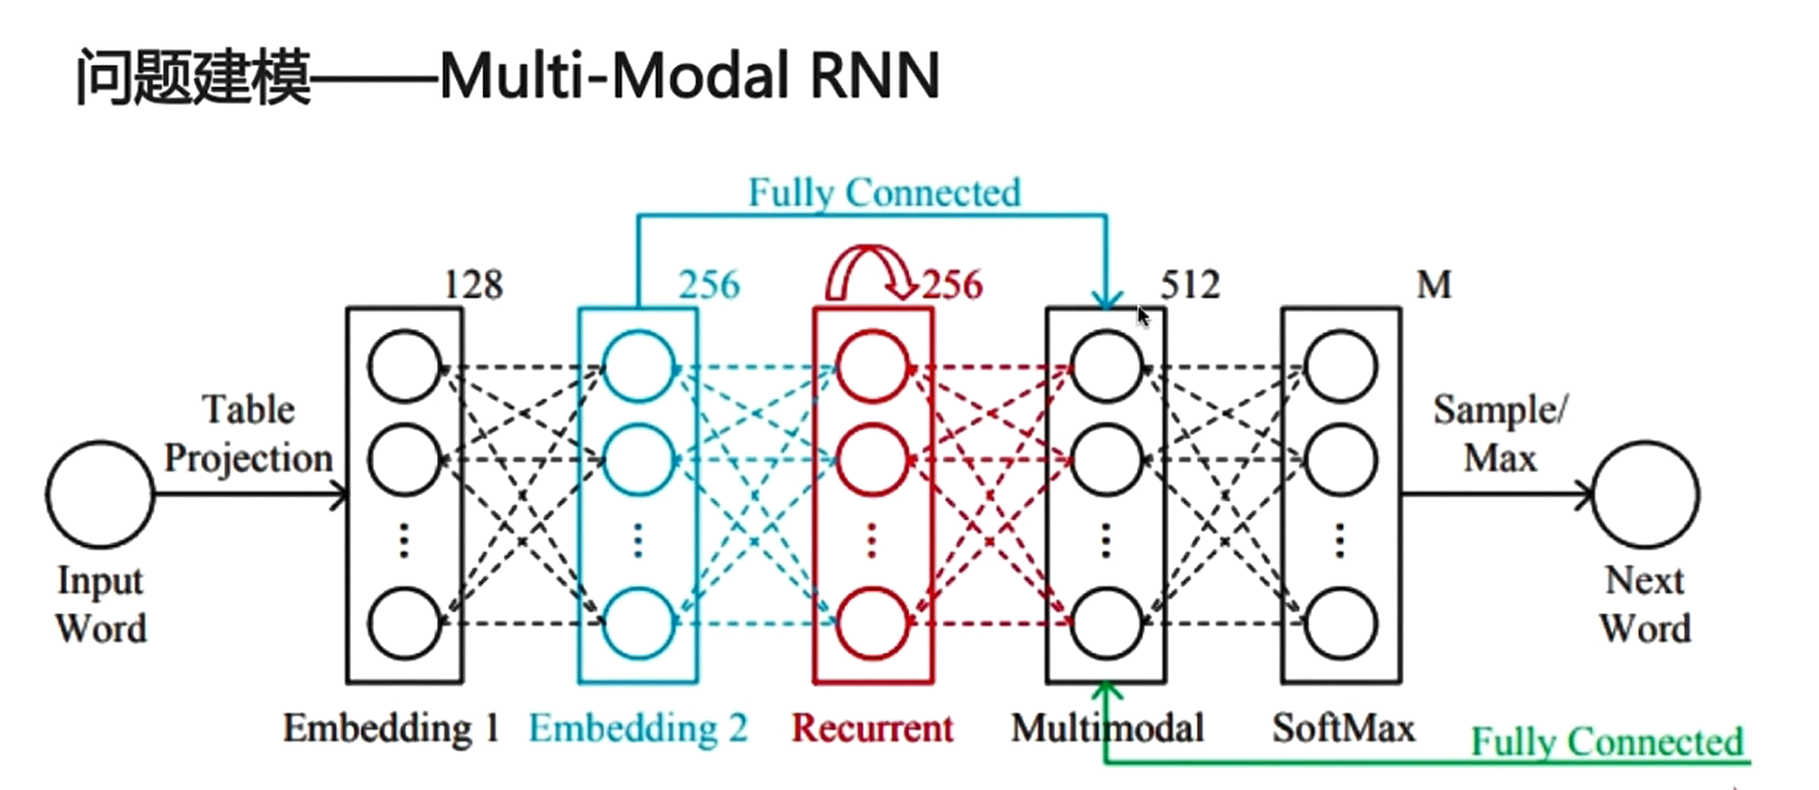
- 每一个普通rnn的输入都是三个的合成(origin embedding + rnn embedding + fc feature)
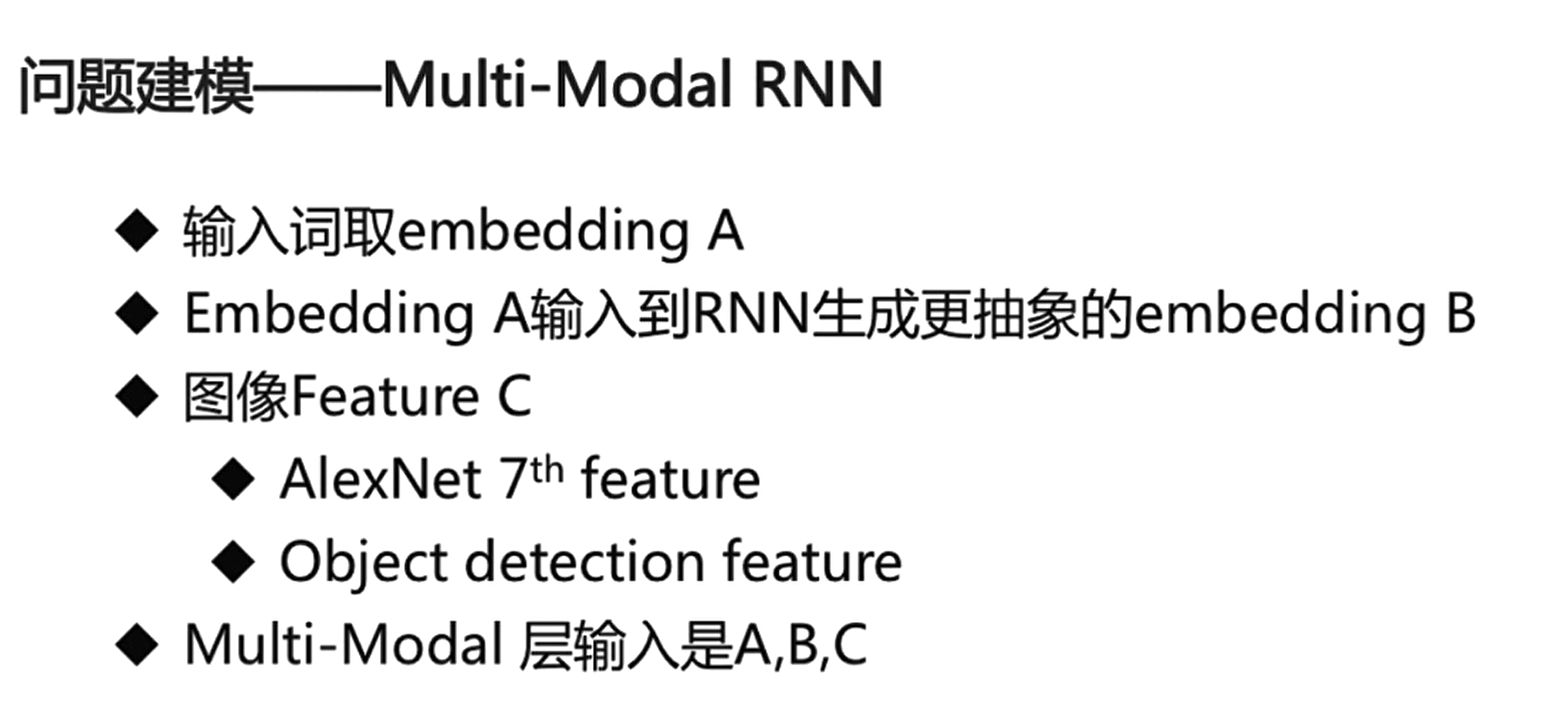
- 百度首先研发 最初版本的 没有LSTM 使用fc图像特征

### model2 - show and tell
- 李飞飞团队研发
- 使用了LSTM 并且对于image feature只在最初层次使用
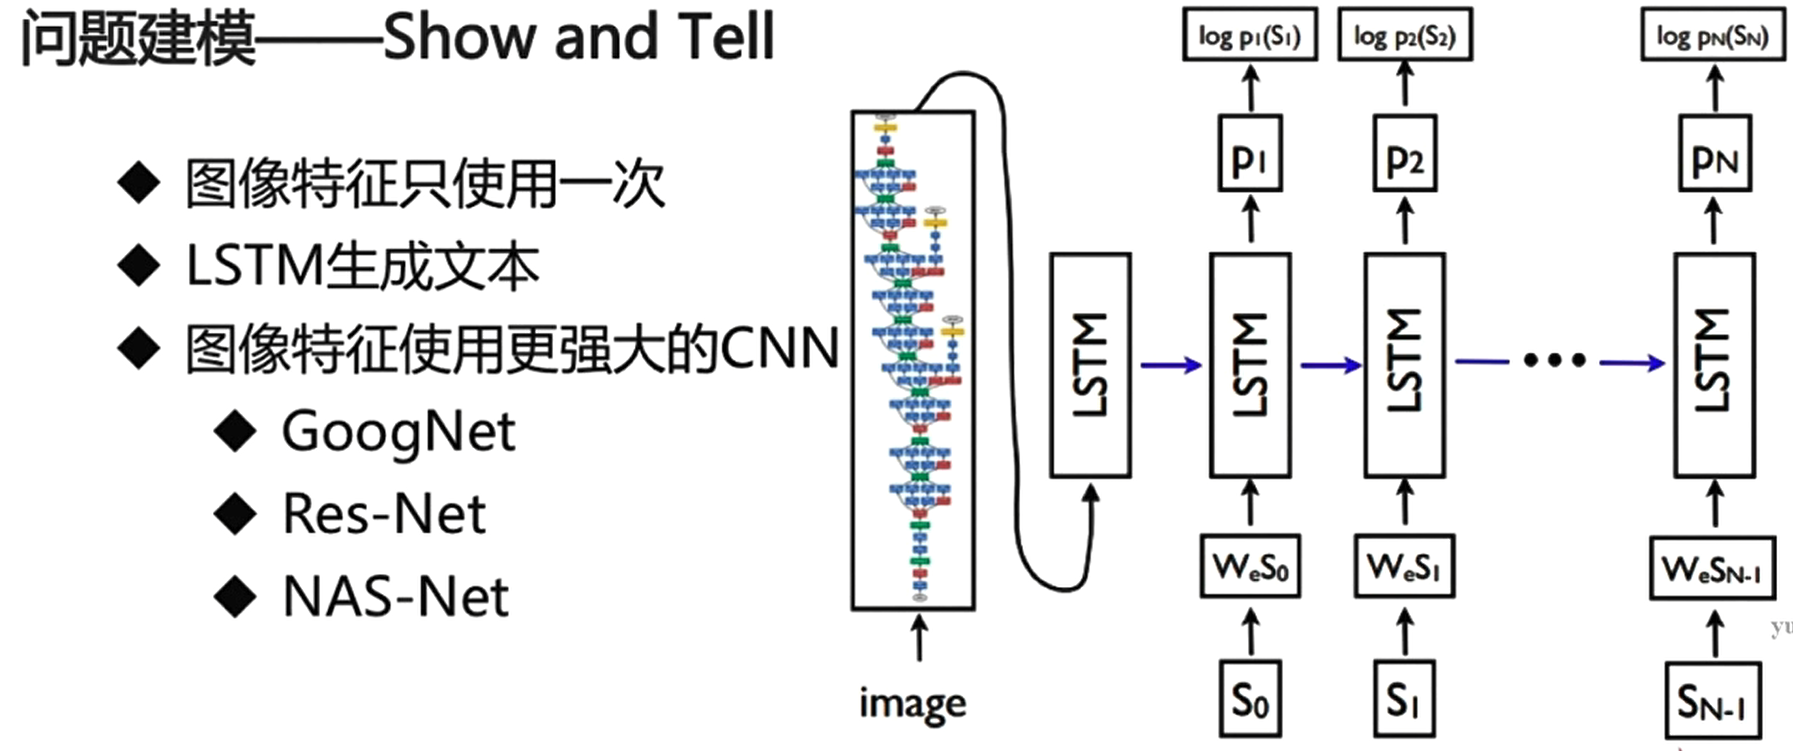

### model3 - show attend and tell
- 李飞飞团队改良 使用LSTM 但是加上了注意力机制
- 基本模型
    - 考虑到每个词语对于图像不同位置feature关注度不同 
    - 所以使用con层的feature从而包含位置信息
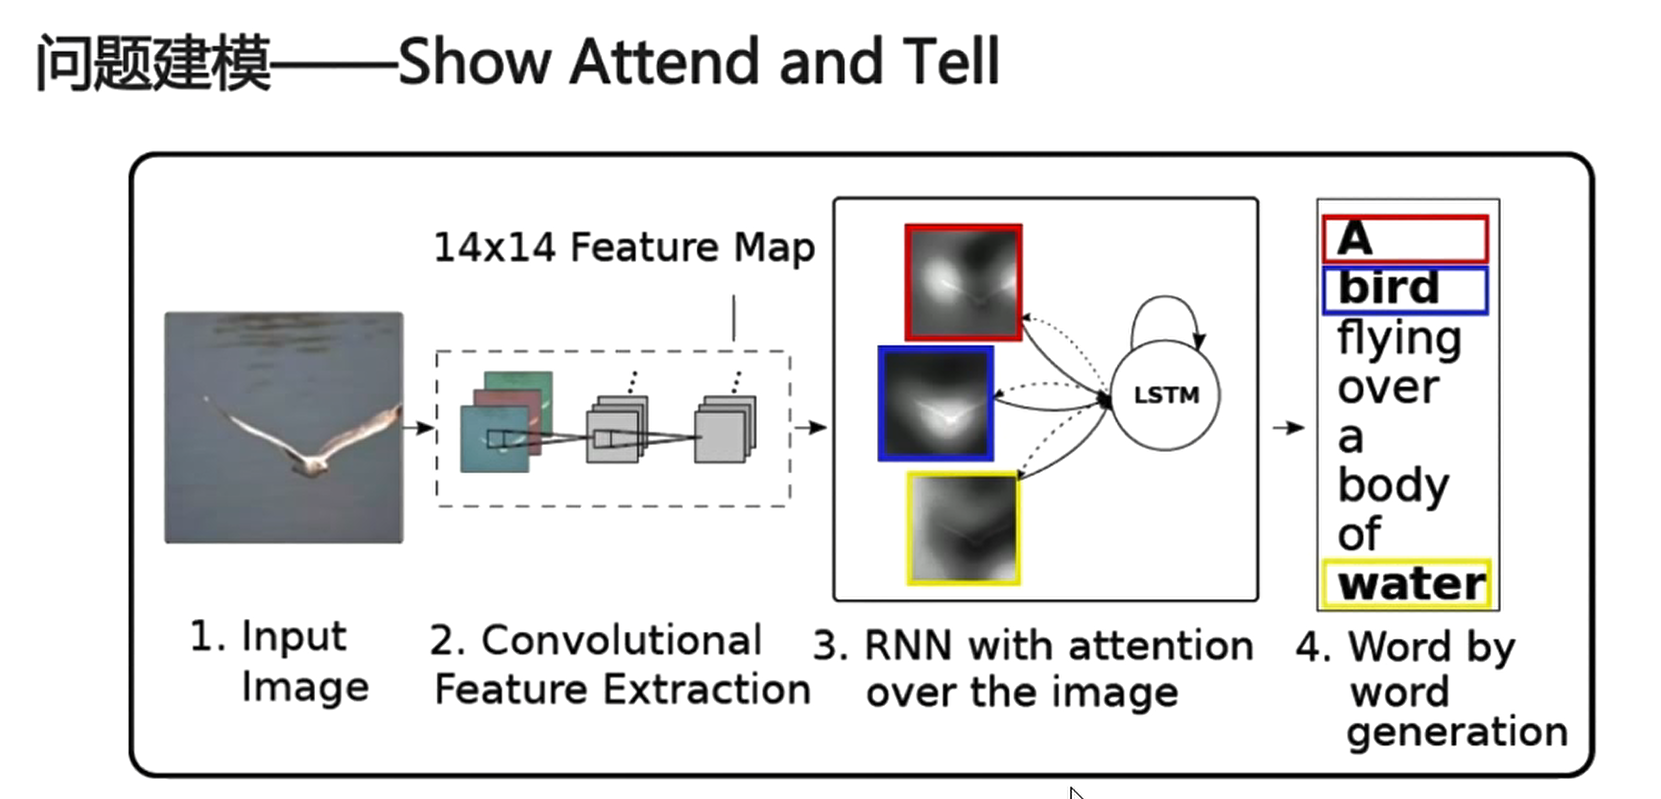
- 注意力机制运算公式 [不同于文本分类中的注意力机制] 
     - (文本分类中的注意力机制对于每个时刻输入产生的输出进行运算得到权值 再与这些输出加权和)
     - 这里是对于图像不同位置的特征(某一个位置所有通道作为一个特征)，与不同时刻输入进行运算得到权值结果 再与这些特征进行加权 由于考虑到了不同输入的影响 所以权值随着输入改变
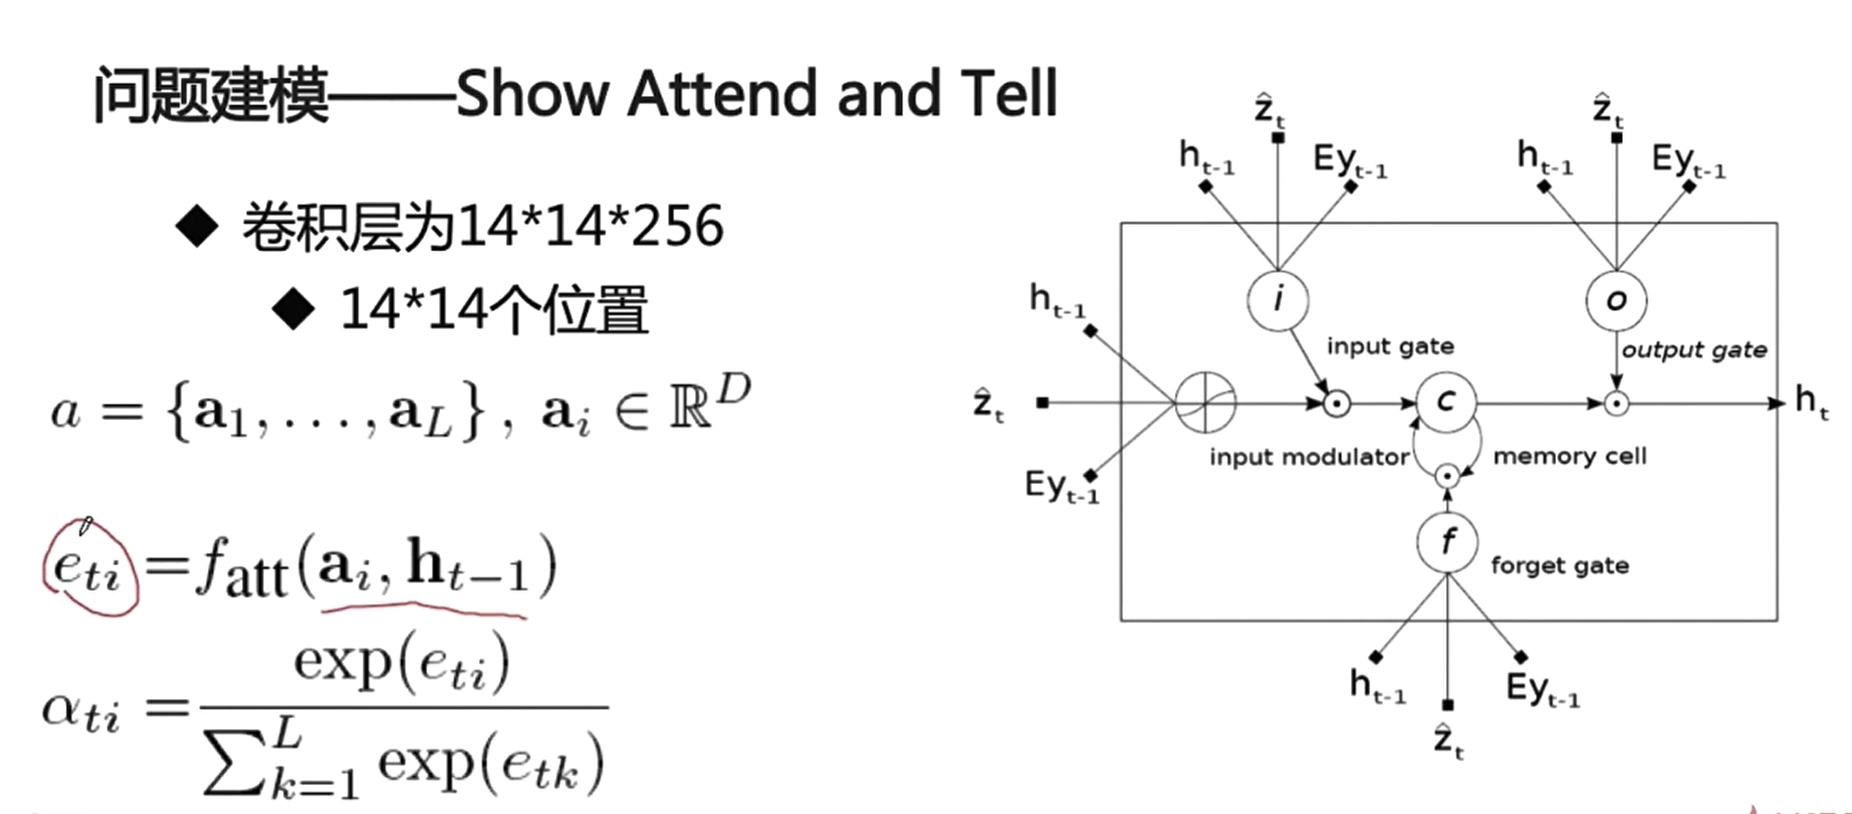
- 相比之前版本改进之处
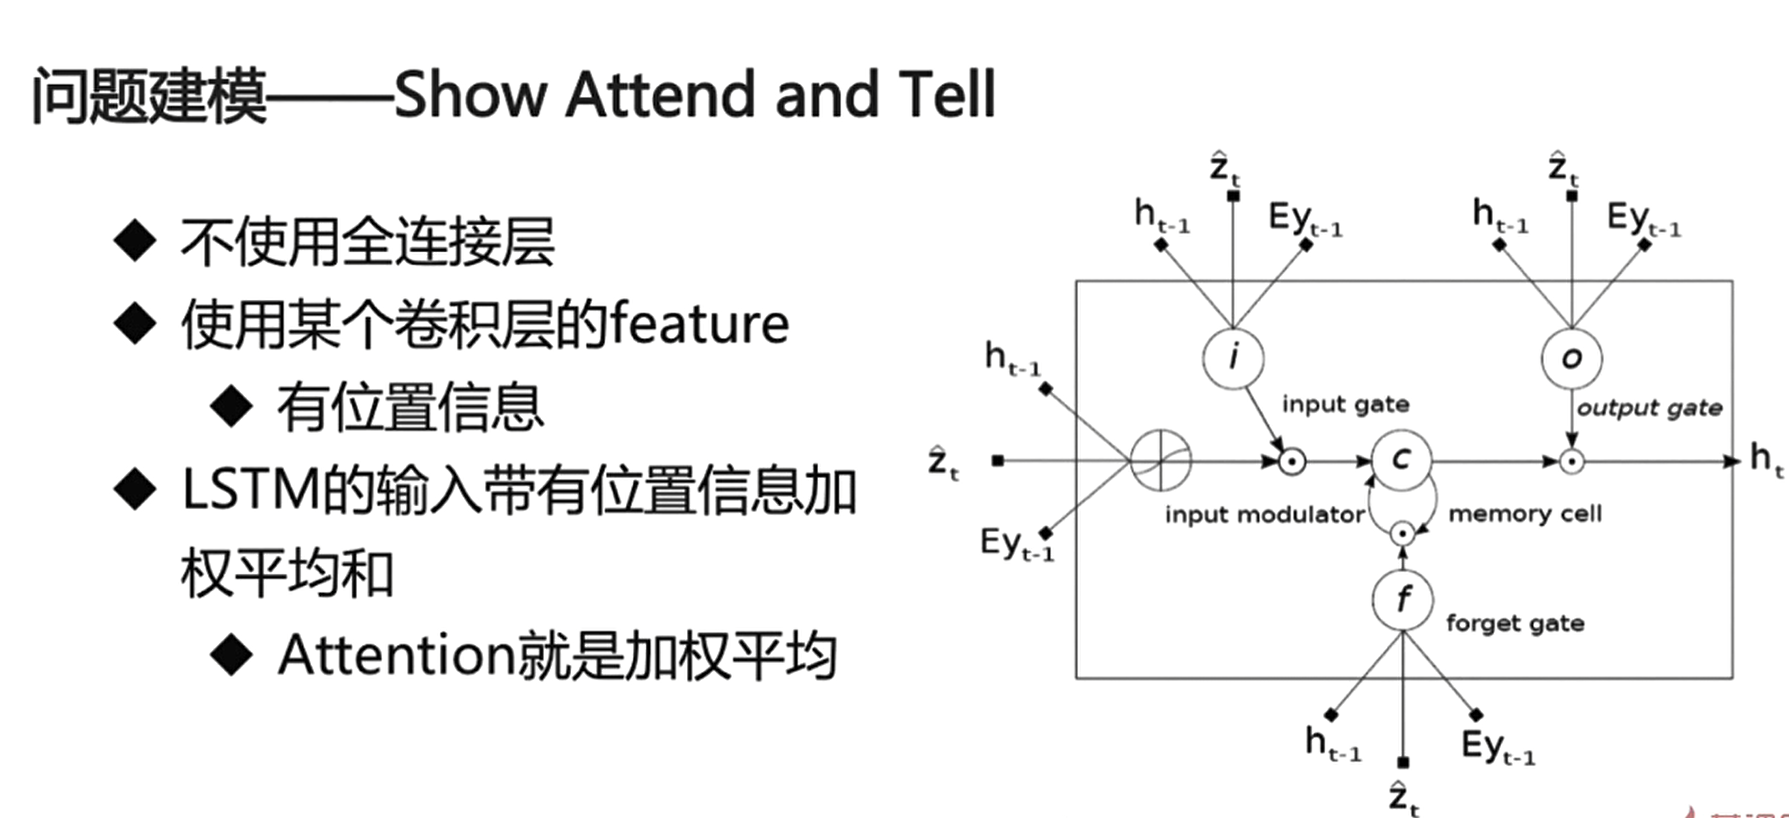
- 例子(体现不同时刻输入的词语对于不同的位置有着不同的关注度)
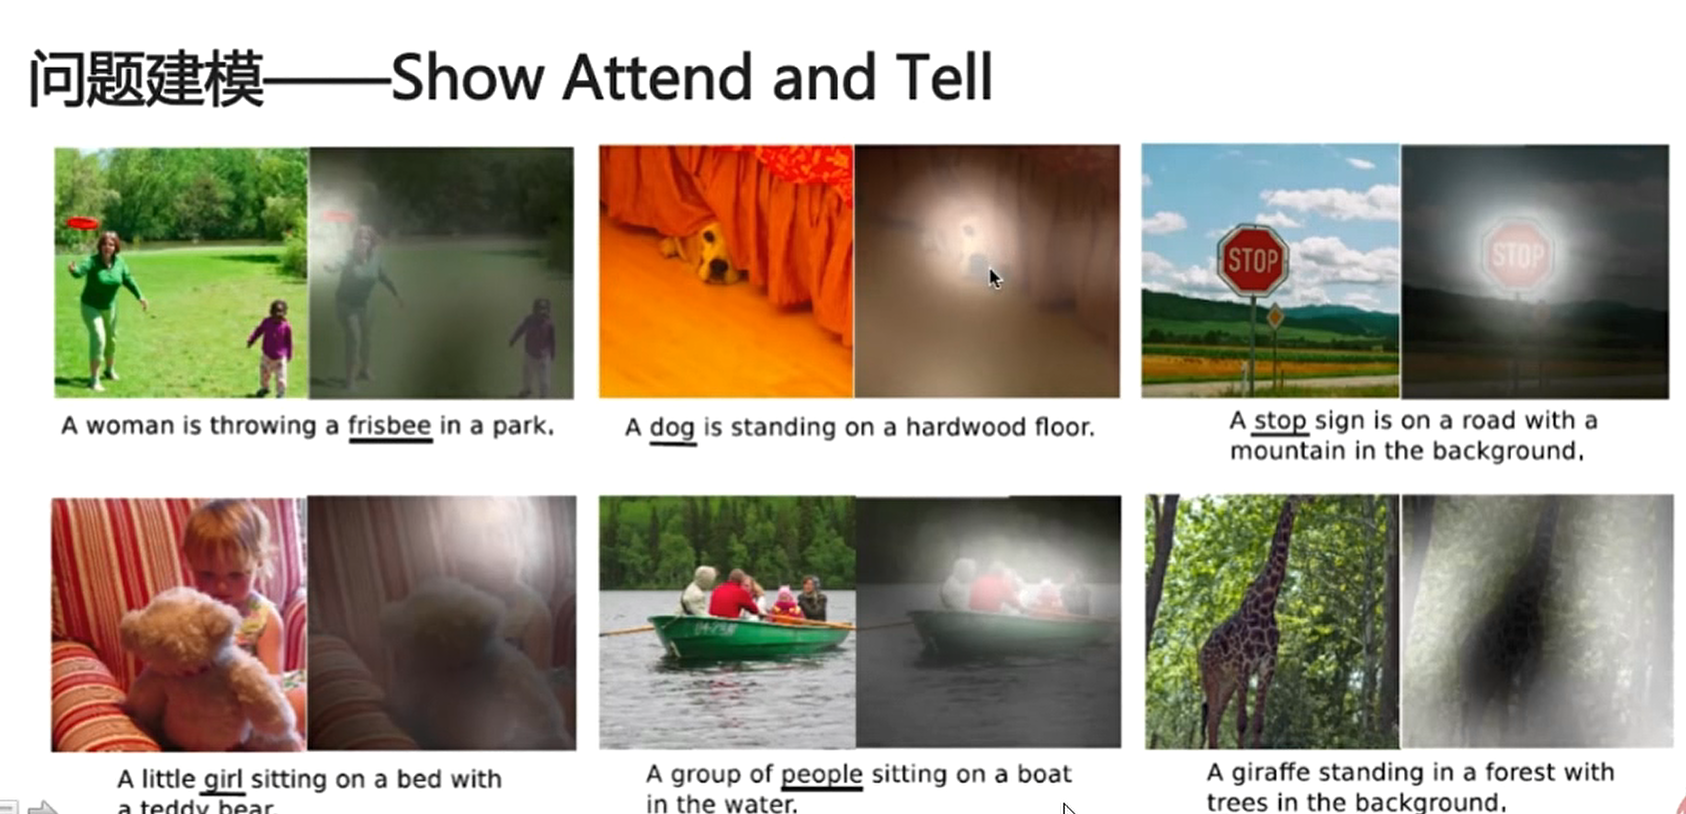

### model4 - top down button up
- 解决model3中一个lstm需要学习注意力 与 生成 从而导致负载过重问题
- 基本结构
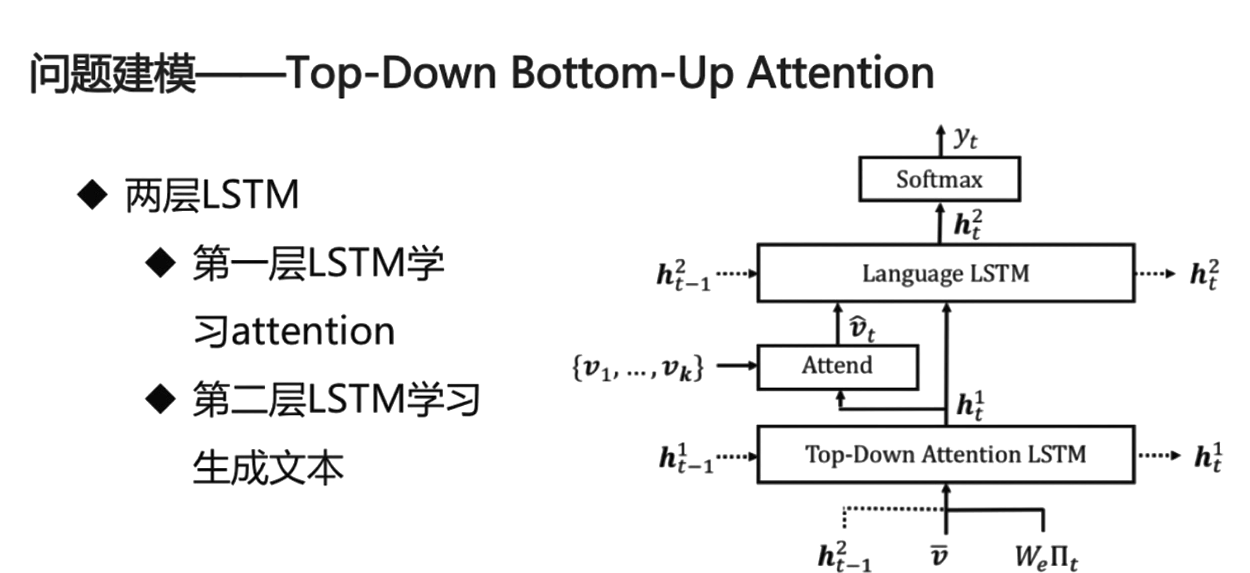
- 每一层的功能以及输入输出解释
    - lstm layer1(学到权值 attention)
    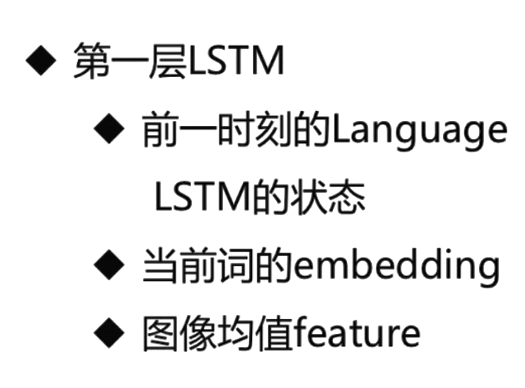
    - attention layer(任务相对少 简单加权即刻)
    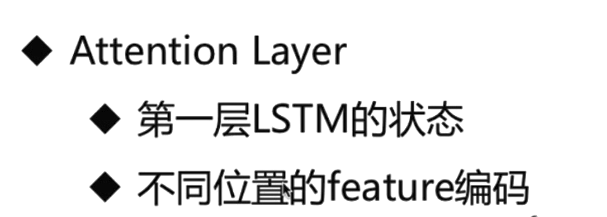
    - lstm layer2(通过输入学会生成)
    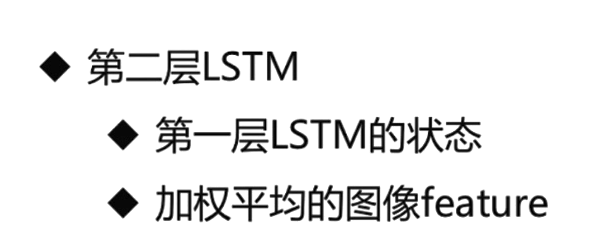
- 特征：对外仍然是一个lstm 但是在内部采用了分层的思想
    - 研究中常用分层思想提高效率 模型简易度 模型效果
    - 对于前一个model的稍加改进 之后形成自己的model 论文 常见
    - 在对外封装上竟可能保持原有不变性 但是内在可以由很大的改变
    
## model contrast
- 四个model的对比 
    - 从输入的图像特征的时机 第二个与1 3 4 有一定区别 
    - 从使用的基本单元上 1 与 2 3 4 有区别 后者用到lstm
    - 从图片特征上 1 2 用全连接层feature ， 3 4 用conv层输入含有位置信息 并且对于位置加权
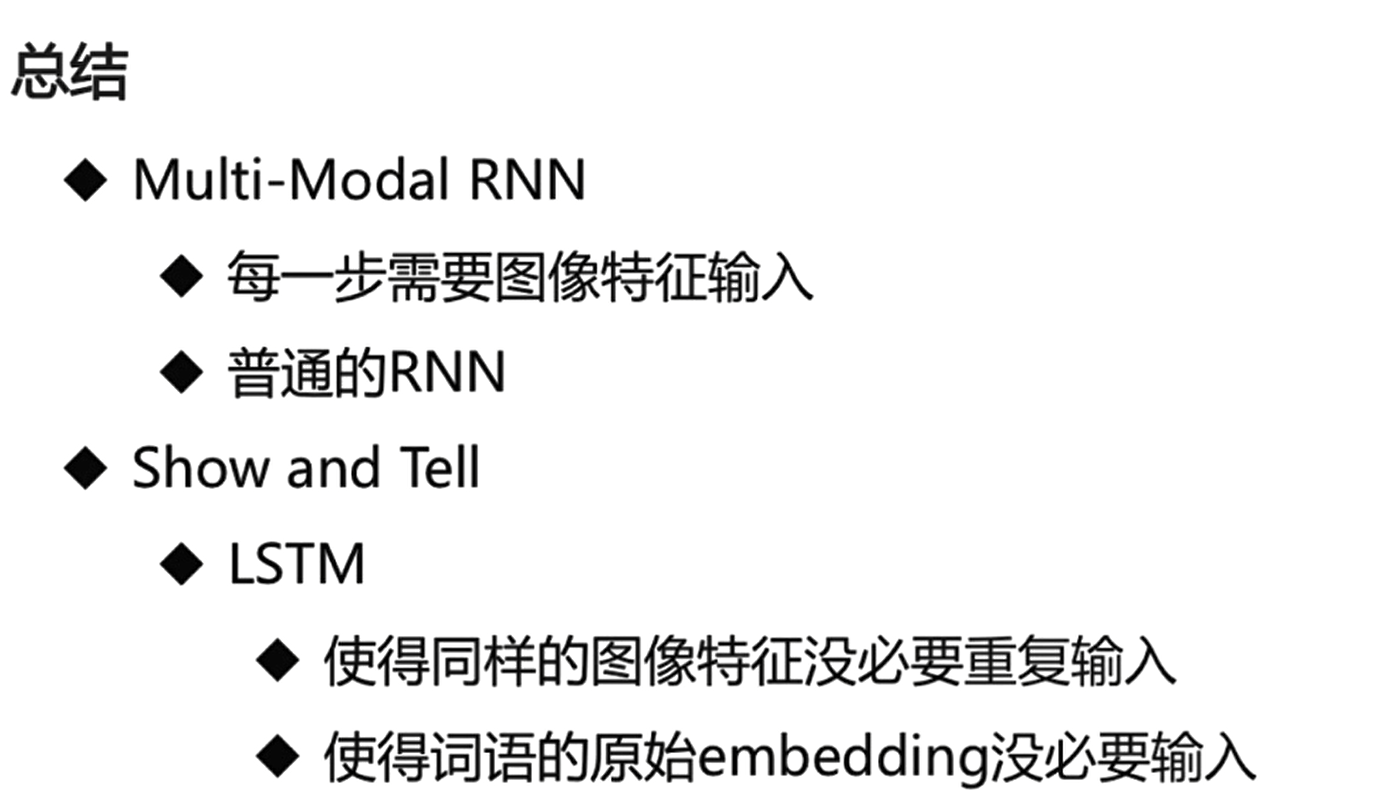
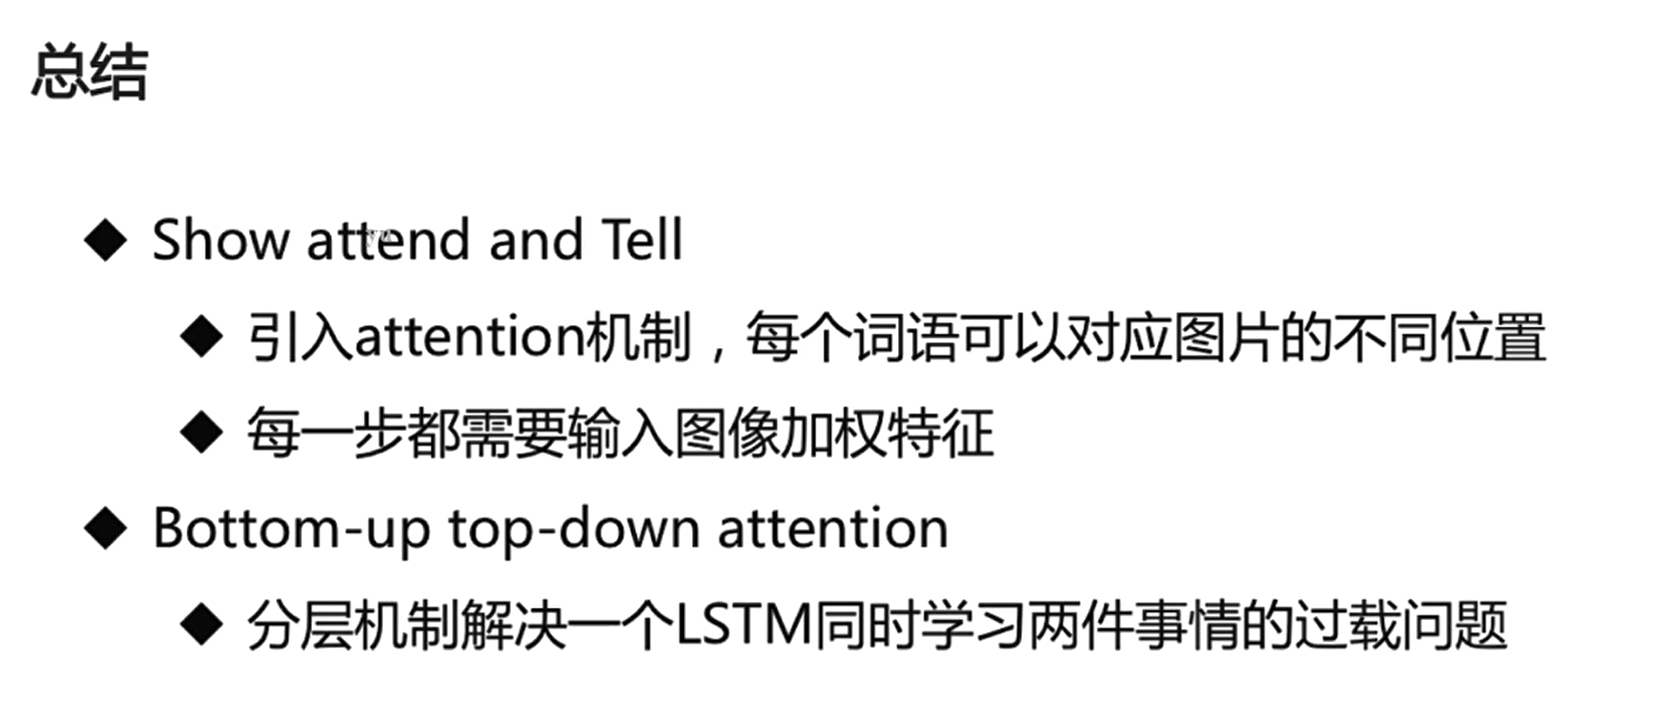


## 本章总结

### 知识点总结
- 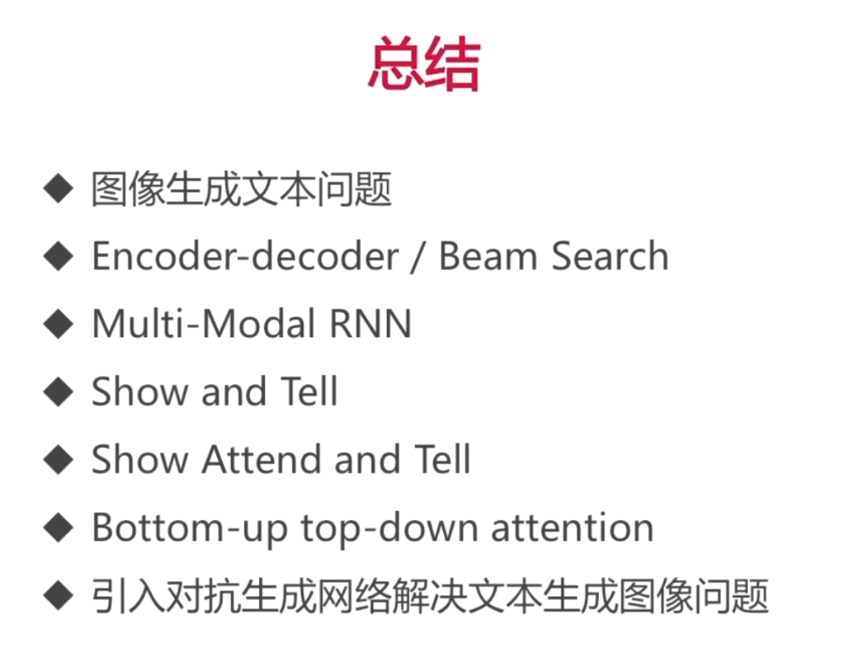
- 评测方法 
### 实战要点

- premodel提取
    - 通过tf提供的保存方式可以实现
        - sess单独保存 -- 重载需要重建图 因为sess中仅仅保存了数值
        - 冻结整张图 -- 重载只需要重载整个graph文件'-.pb' 并且import 即可
            - inception v3 使用这种方式
            - 提取的时候需要事先了解网络结构 通过tf.name得到具体的tensor
            
    - 通过npy文件读取模型参数
        - 如果通过npy保存参数仍然需要解析npy文件 重建图 之后手动写入参数
 
 > 相比之下 sess保存更加便捷 但是灵活度稍差 
 npy相对麻烦 重建通常使用底层api 但是相对灵活
 
 > 问题：如何指定通过pb文件导入的图的可训练性 还是说默认不可训练？？？
 
 
 
- 常用套路
     - 文本问题：分词->统计得到词表->词表封装(sentence2id)(删去不常用词 提供<UNK\>)->dataset 提供inputs(对齐从而调整长度)
     - 图像(提取特征)问题: 读取图像->输入cnn->得到某层输出作为抽象特征->dataset 提供inputs
     - rnn使用：通常采取num_timesteps 实现batch对齐 这一点cnn作用时必须有 rnn作用时可以没有 但是加上更方便
     - rnn搭建 cell->\[multicell\]->dynamic_rnn(多步)/cell.call(单步)
     - rnn输入 由于有图像特征 在作为初始输入 可以将图像特征fc成与embedding_size西安同大小的特征 方便一次调用
     - rnn防止梯度爆炸 的grad_clip 梯度消失lstm gru可以抑制